# Prepare street names for classification
In diesem Notebook werden die Daten des [Amtliches Verzeichnis der Strassen](https://www.cadastre.ch/de/services/service/registry/street.html) der swisstopo explorativ begutachtet.

# Load Dataset

In [100]:
import urllib.request
    
url = 'https://data.geo.admin.ch/ch.swisstopo.amtliches-strassenverzeichnis/csv/2056/ch.swisstopo.amtliches-strassenverzeichnis.zip'
filehandle, _ = urllib.request.urlretrieve(url)

from zipfile import ZipFile
 
with ZipFile(filehandle, 'r') as zip:
    #zip.printdir()
    data = zip.read("pure_str.csv")
    
import chardet

result = chardet.detect(data)
print(result)
print(type(data))
    
from io import StringIO
import pandas as pd

daten = StringIO(str(data,'UTF-8-SIG'))

streetnames = pd.read_csv(daten, encoding='UTF-8-SIG', sep=';')
streetnames.head()  


{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}
<class 'bytes'>


,STR_ESID,STN_LABEL,ZIP_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_TYPE,STR_STATUS,STR_OFFICIAL,STR_VALID,STR_MODIFIED,STR_EASTING,STR_NORTHING
0,10258316,Eggwald,6484 Wassen UR,1220,Wassen,UR,Place,real,True,False,10.09.2022,NaN,NaN
1,10023770,Wiedenweg,4203 Grellingen,2786,Grellingen,BL,Street,real,True,True,09.09.2022,2610733.0,1254311.0
2,10179192,Wuhrbärgli,4253 Liesberg,2788,Liesberg,BL,Street,real,True,True,26.08.2022,2598709.0,1249640.0
3,10250501,Hüethütte Unter Trübsee,6390 Engelberg,1511,Wolfenschiessen,NW,Area,real,True,True,07.08.2021,2671798.0,1184817.0
4,10163108,Heimstenstich,4436 Liedertswil,2890,Liedertswil,BL,Area,real,True,True,03.03.2022,2621856.0,1248672.0


# Clean Dataset

Keep only streets (remove areas and places)
Total streetnames = 221'253 
Only with STR_TYPE = Street = 171'966 

In [101]:
streetnames = streetnames[streetnames.STR_TYPE == 'Street']

Check for missing data & remove 108 missing values in STR_EASTING & STR_NORTHING

In [102]:
missing_data = pd.DataFrame(
    streetnames.isnull().sum(),
    columns=['Missing Values'])

print(missing_data)

streetnames = streetnames.dropna()

              Missing Values
STR_ESID                   0
STN_LABEL                  0
ZIP_LABEL                  0
COM_FOSNR                  0
COM_NAME                   0
COM_CANTON                 0
STR_TYPE                   0
STR_STATUS                 0
STR_OFFICIAL               0
STR_VALID                  0
STR_MODIFIED               0
STR_EASTING              108
STR_NORTHING             108


    Adding data types to streetname dataset

In [103]:
data_types = pd.DataFrame(
    streetnames.dtypes,
    columns=['Data Type'])

print(data_types)

             Data Type
STR_ESID         int64
STN_LABEL       object
ZIP_LABEL       object
COM_FOSNR        int64
COM_NAME        object
COM_CANTON      object
STR_TYPE        object
STR_STATUS      object
STR_OFFICIAL      bool
STR_VALID         bool
STR_MODIFIED    object
STR_EASTING    float64
STR_NORTHING   float64


Check if the values are unique and analyze values in columns

In [104]:
unique_values = pd.DataFrame(
    columns=['Unique Values'])
      
for row in list(streetnames.columns.values):
    unique_values.loc[row] = [streetnames[row].nunique()]
    
print(unique_values)

streetnames.groupby('STR_VALID').size()
   

              Unique Values
STR_ESID             171858
STN_LABEL             96355
ZIP_LABEL              6456
COM_FOSNR              2082
COM_NAME               2082
COM_CANTON               26
STR_TYPE                  1
STR_STATUS                2
STR_OFFICIAL              2
STR_VALID                 2
STR_MODIFIED            159
STR_EASTING          122670
STR_NORTHING         101846


STR_VALID
False      4705
True     167153
dtype: int64

Remove columns that are no longer needed
Removed information:
STR_VALID == False: 4705
STR_STATUS == planned: 183
STR_OFFICIAL == False: 537
STR_TYPE: all Street
COM_FOSNR: No analysis per ZIP planned
STR_MODIFIED: All recently modified (oldest in 2021)

In [105]:
streetnames = streetnames.drop ('STR_TYPE', axis=1)
streetnames = streetnames.drop ('STR_VALID', axis=1)
streetnames = streetnames.drop ('STR_STATUS', axis=1)
streetnames = streetnames.drop ('STR_OFFICIAL', axis=1)
streetnames = streetnames.drop ('ZIP_LABEL', axis=1)
streetnames = streetnames.drop ('STR_MODIFIED', axis=1)

# Remove and move street terms in new column

Most common street names

In [106]:
most_common = streetnames.groupby("STN_LABEL").count()
most_common.COM_FOSNR.nlargest(10)

STN_LABEL
Dorfstrasse         637
Bahnhofstrasse      518
Hauptstrasse        484
Birkenweg           321
Kirchweg            313
Schulstrasse        293
Oberdorfstrasse     268
Industriestrasse    259
Schulhausstrasse    244
Rosenweg            243
Name: COM_FOSNR, dtype: int64

Count and visualize steet terms (case sensitive)
DE: 'wegli', 'strasse', 'weg', 'platz', 'gasse', 'gässli', 'wäg',
FR: 'avenue ', 'ave. ', 'boulevard ', 'chemin ', 'impasse ', 'place', 'route ', 'rue ', 'ruelle ', 
IT: 'piazza ', 'via ', 'viale '


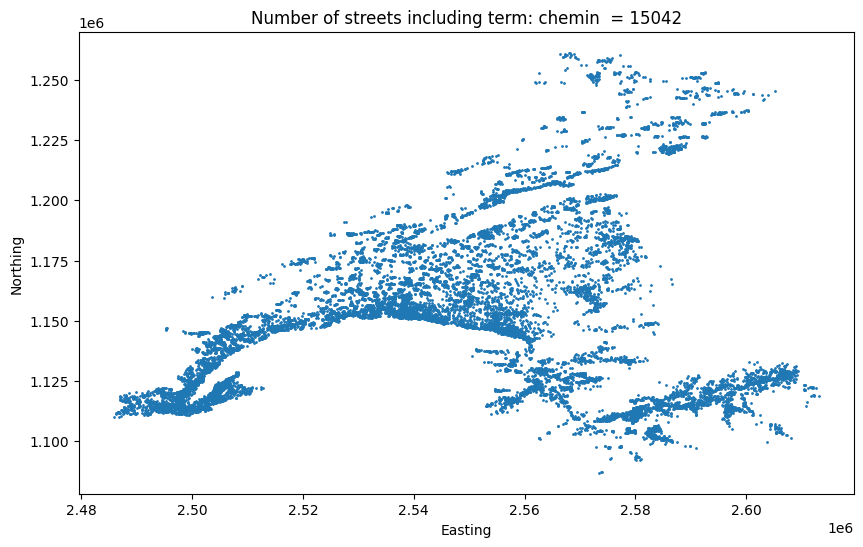

In [107]:
import matplotlib.pyplot as plt

searchString = "chemin "
searchStringStrassen = streetnames.loc[streetnames.STN_LABEL.str.contains(searchString, case=False)]
count = len(searchStringStrassen)
count = "Number of streets including term: "+ searchString + " = "+  str(count)

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(x=searchStringStrassen['STR_EASTING'], y=searchStringStrassen['STR_NORTHING'], s = 1)
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(count)
plt.show()

Duplicate column of street names

In [108]:
streetnames ['STN_LABEL_NO_TERMS'] = streetnames.loc[:, 'STN_LABEL']

Move and replace street terms

In [109]:
terms = ('strasse', 'weg', 'platz', 'gasse', 'gässli', 'wäg', 'strässli', 'wegli',
'avenue ', 'ave. ', 'boulevard ', 'chemin ', 'impasse ', 'place ', 'route ', 'rue ', 'ruelle ', 'passage ', 
'piazza ', 'via ', 'viale ',
'strada ', 'veia ', 'vietta ', 'gassa ', 'voia ','voa')

for i in terms:
    streetnames.loc[streetnames.STN_LABEL.str.contains(i,case=False), 'STR_TERMS'] = i
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i, '',case=False, regex=True)


In [110]:
streetnames.groupby('STR_TERMS',dropna=False).size()

STR_TERMS
ave.              3
avenue          708
boulevard        32
chemin        15030
gassa            47
gasse          3761
gässli         1008
impasse        1148
passage         272
piazza           39
place           168
platz           615
route          6787
rue            6290
ruelle          704
strada          316
strasse       49058
strässli         15
veia            157
via            6703
viale            51
vietta           26
voa              59
voia             49
weg           43181
wegli           229
wäg             236
NaN           35166
dtype: int64

In [111]:
streetnames.head()

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_EASTING,STR_NORTHING,STN_LABEL_NO_TERMS,STR_TERMS
1,10023770,Wiedenweg,2786,Grellingen,BL,2610733.0,1254311.0,Wieden,weg
2,10179192,Wuhrbärgli,2788,Liesberg,BL,2598709.0,1249640.0,Wuhrbärgli,NaN
9,10140563,Emanuelenweg,2829,Liestal,BL,2623078.0,1257558.0,Emanuelen,weg
13,10069457,Löhrweg,2850,Känerkinden,BL,2630229.0,1251411.0,Löhr,weg
15,10096235,Brunngasse,2833,Seltisberg,BL,2621406.0,1256852.0,Brunn,gasse


# Remove and move street terms in new column

First replace special caracters

In [112]:
special = (['.', ' '],[',', ' '],[';', ' '],[':', ' '],['-', ' '],['\'', ' '],[',', ' '],[' ', ' '],
['è', 'e'],['é', 'e'],['ê', 'e'],['ë', 'e'],['à', 'a'],['á', 'a'],['â', 'a'],['ô', 'o'],['ò', 'o'],['ó', 'o'],
['û', 'u'],['ù', 'u'],['ú', 'u'],['ï', 'i'],['í', 'i'],['î', 'i'],['ç', 'c'])

for i in special:
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],i[1],case=False, regex=True)

In [113]:
terms = (['hinterer ', 'hinter'],['hinteren ', 'hinter'],['hinteres ', 'hinter'],['hintere ', 'hinter'],['hinter ', 'hinter'],
['oberen ', 'ober'],['oberer ', 'ober'],['oberes ', 'ober'],['obere ', 'ober'],['ober ', 'ober'],
['vorderen ', 'vorder'],['vorderer ', 'vorder'],['vorderes ', 'vorder'],['vordere ', 'vorder'],['vorder ', 'vorder'],
['unteren ', 'unter'],['unterer ', 'unter'],['unteres ', 'unter'],['untere ', 'unter'],['unter ', 'unter'],
['mittleren ', 'mittler'],['mittlerer ', 'mittler'],['mittleres ', 'mittler'],['mittlere ', 'mittler'],['mittler ', 'mittler'],
['äusseren ', 'äusser'],['äusserer ', 'äusser'],['äusseres ', 'äusser'],['äussere ', 'äusser'],['äusser ', 'äusser'],
['inneren ', 'inner'],['innerer ', 'inner'],['inneres ', 'inner'],['innere ', 'inner'],['inner ', 'inner'],
['kleines ', 'klein'],['kleiner ', 'klein'],['kleinen ', 'klein'],['kleine ', 'klein'],['klein ', 'klein'],['petite ', 'klein'],['petit ', 'klein'],
['grosses ', 'gross'],['grosser ', 'gross'],['grossen ', 'gross'],['grosse ', 'gross'],['gross ', 'gross'],['grand ', 'gross'],['grande ', 'gross'],
['san ', 'sankt'],['santa ', 'sankt'],['sankt ', 'sankt'],['saint ', 'sankt'],['sainte ', 'sankt'],
['ancien ', 'alt'],['ancienne ', 'alt'],['alte ', 'alt'],['alter ', 'alt'],['altes ', 'alt'],['alten ', 'alt'],
['mont ', 'mont'])

for i in terms:
    streetnames.loc[streetnames.STN_LABEL_NO_TERMS.str.contains(i[0],case=False), 'STR_PREPS'] = i[1]
    streetnames['STN_LABEL_NO_TERMS'] = streetnames['STN_LABEL_NO_TERMS'].str.replace(i[0],'',case=False)

In [114]:
streetnames.groupby('STR_PREPS',dropna=False).size()

STR_PREPS
alt          1176
gross         459
hinter        361
inner          62
klein         271
mittler       182
mont          117
ober         1532
sankt         577
unter        1332
vorder        199
äusser         62
NaN        165528
dtype: int64

In [115]:
i = 'Wuhr'
streetnames.loc[streetnames['STN_LABEL_NO_TERMS'].str.startswith(i), 'test'] = i
streetnames


,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_EASTING,STR_NORTHING,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,test
1,10023770,Wiedenweg,2786,Grellingen,BL,2610733.0,1254311.0,Wieden,weg,NaN,NaN
2,10179192,Wuhrbärgli,2788,Liesberg,BL,2598709.0,1249640.0,Wuhrbärgli,NaN,NaN,Wuhr
9,10140563,Emanuelenweg,2829,Liestal,BL,2623078.0,1257558.0,Emanuelen,weg,NaN,NaN
13,10069457,Löhrweg,2850,Känerkinden,BL,2630229.0,1251411.0,Löhr,weg,NaN,NaN
15,10096235,Brunngasse,2833,Seltisberg,BL,2621406.0,1256852.0,Brunn,gasse,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
221245,10107114,Tannenstrasse,4471,Bischofszell,TG,2736565.0,1261881.0,Tannen,strasse,NaN,NaN
221246,10070806,Rebenstrasse,4724,Eschlikon,TG,2716120.0,1258548.0,Reben,strasse,NaN,NaN
221248,10142291,Fritz-Gegauf-Strasse,4864,Steckborn,TG,2715726.0,1280124.0,Fritz Gegauf,strasse,NaN,NaN
221250,10093237,Obere Bleichewiese,4571,Gachnang,TG,2705606.0,1266777.0,Bleichewiese,NaN,ober,NaN


In [130]:
streetnames ['STN_LABEL_FINAL'] = streetnames.loc[:, 'STN_LABEL_NO_TERMS']

In [132]:
stop = ('le' ,'la' , 'en' , 'au' , 'da' ,'im' , 'in' , 'ai' , 'al' ,
        'am' , 'l''','a'  ,'les', 'auf', 'aux', 'bei','der', 'die', 
        'das','zum', 'beim', 'de', 'des', 'du', 'd''', 'della', 'alla', 
        'di', 'delle', 'del', 'dei')

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.lower().str.split(' ')

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].apply(lambda x: [item for item in x if item not in stop])

streetnames['STN_LABEL_FINAL'] = streetnames['STN_LABEL_FINAL'].str.join(' ')

streetnames.head(30)

,STR_ESID,STN_LABEL,COM_FOSNR,COM_NAME,COM_CANTON,STR_EASTING,STR_NORTHING,STN_LABEL_NO_TERMS,STR_TERMS,STR_PREPS,test,STN_LABEL_TEST,STN_LABEL_FINAL
1,10023770,Wiedenweg,2786,Grellingen,BL,2610733.0,1254311.0,Wieden,weg,NaN,NaN,wieden,wieden
2,10179192,Wuhrbärgli,2788,Liesberg,BL,2598709.0,1249640.0,Wuhrbärgli,NaN,NaN,Wuhr,wuhrbärgli,wuhrbärgli
9,10140563,Emanuelenweg,2829,Liestal,BL,2623078.0,1257558.0,Emanuelen,weg,NaN,NaN,emanuelen,emanuelen
13,10069457,Löhrweg,2850,Känerkinden,BL,2630229.0,1251411.0,Löhr,weg,NaN,NaN,löhr,löhr
15,10096235,Brunngasse,2833,Seltisberg,BL,2621406.0,1256852.0,Brunn,gasse,NaN,NaN,brunn,brunn
17,10118344,Beckengässli,2882,Bennwil,BL,2625714.0,1250261.0,Becken,gässli,NaN,NaN,becken,becken
19,10103841,Poststrasse,2831,Pratteln,BL,2620726.0,1264894.0,Post,strasse,NaN,NaN,post,post
20,10103030,Bromhübelweg,2763,Arlesheim,BL,2613595.0,1260018.0,Bromhübel,weg,NaN,NaN,bromhübel,bromhübel
21,10108763,Zurlindenstrasse,2831,Pratteln,BL,2619392.0,1264175.0,Zurlinden,strasse,NaN,NaN,zurlinden,zurlinden
22,10209066,Bergli,1323,Wollerau,SZ,2694144.0,1226051.0,Bergli,NaN,NaN,NaN,bergli,bergli


In [137]:
streetnames.to_csv('C:\CAS_Arbeit\cassda-zertifikatsarbeit\Datapreparation\streetnames.csv', encoding='UTF-8-SIG', sep=';')

we assume that only one designation exists